In [1]:
import svgpathtools as spt
from svgpathtools import parse_path, Line, Path, wsvg, Arc, disvg
import numpy as np
import math

import tempfile, os
from IPython.display import SVG, display

import warnings

def disp_svg(paths):
    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_svg = os.path.join(tmp_dir, 'display.svg')
        spt.wsvg(paths, filename = tmp_svg)
        ## Possible add something like this to get transforming y-axis
        ## Possible needs a group wrapper on all objects
        # spt.wsvg(paths, filename = 'out_test.svg',svg_attributes={'transform':'matrix(1 0 0 -1 0 400)'})

        display(SVG(tmp_svg))

def save_svg(paths, name, params):
    spt.wsvg(paths,filename = f'pathout_{name}_{params}.svg', baseunit='mm',mindim=None)


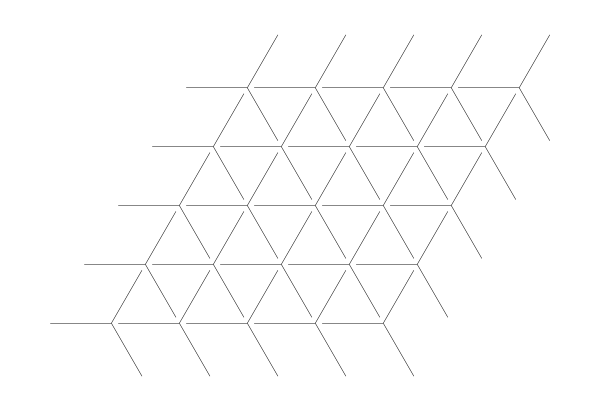

In [2]:
num_elem=3
theta=2*np.pi/num_elem

r0=0.9

paths=[]

x0 = 0
x1 = -1*r0

basis = Path()
for i in range(num_elem):
    basis.append(spt.Line(x0,x1*np.exp(-i*1j*theta)))
    

lattice = [-1*np.exp(1j*theta),1.0] ## Lattice vectors

nx=5
ny=5

for i in range(nx):
    for j in range(ny):
        paths.append(basis.translated(i*lattice[0] + j * lattice[1]))

disp_svg(paths)

1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0


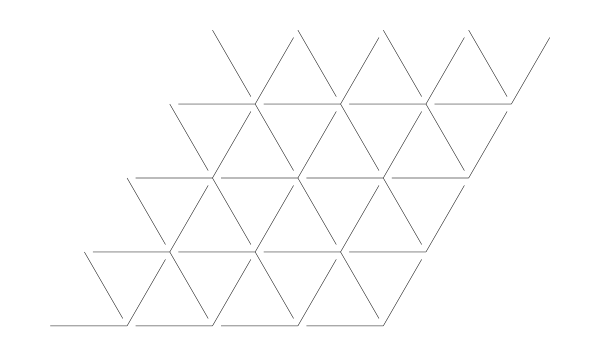

In [3]:
num_elem=3
theta=2*np.pi/num_elem

a=1.0
b=1.0
r0=0.9

lattice = [-a*np.exp(1j*theta),b] ## Lattice vectors

paths=[]

## primary linepiece
x0 = 0
x1 = -1*r0

## Construct the unit cell
unitcell = Path()
for i in range(num_elem - 1):
    unitcell.append(spt.Line(x0,x1*np.exp(i*1j*theta)))
    
unitcell.append(spt.Line(x0,x1*np.exp(-1j*theta)).translated(lattice[0] - lattice[1]))


nx=4
ny=4

for y in range(ny):
    for x in range(nx):
        print(i,j%2)
        paths.append(unitcell.translated(y*lattice[0] + x))
        
## Fence
# paths.append(spt.Line(-1,-1 + 1*nx))
# paths.append(spt.Line(-1,-1 + lattice[0]*ny))

# paths.append(spt.Line(-1 + lattice[0]*ny,
#                       -1 + 1*nx + lattice[0]*ny))

# paths.append(spt.Line(-1 + 1*nx,
#                         1*nx -1 + lattice[0]*ny))

disp_svg(paths)

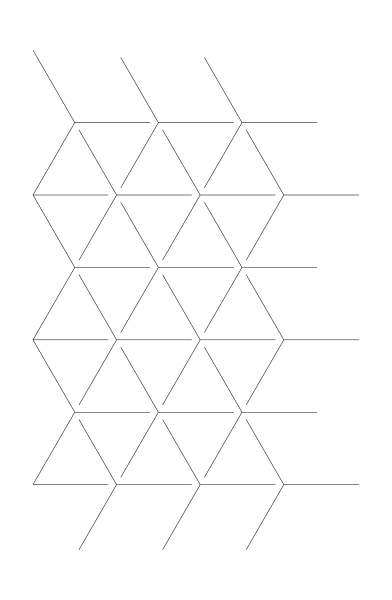

In [4]:
num_elem=3

## Angle as taken from 
theta=2*np.pi/num_elem

a=1.0
b=1.0
r0=0.9

## Basis vectors 
## Theta is considered to be starting from unit circle 0
basis = [1, np.exp(1j*(np.pi - theta))] 
b1,b2=basis

paths=[]

## primary linepiece (horizontal x)
## This one only goes to a fraction of the basis vector
x0,x1 = 0,r0*b1

## Construct the unit cell
unitcell = Path()
for n in range(num_elem):
    x,y =(x0,x1*np.exp(n*1j*theta))
    y=np.conjugate(y)  ## Flip because svg coord system
    unitcell.append(spt.Line(x,y))


### Edge elements
###
###
x0,x1 = 0,r0*b1

edge_l = Path()

## Line on right is still at r0
x,y =(x0,x1)
edge_l.append(spt.Line(x,y))
## Lines left are basis vector based.. i.e. full length
x0,x1 = 0,b1
for n in range(1,num_elem):
    x,y =(x0,x1*np.exp(n*1j*theta))
    y=np.conjugate(y)  ## Flip because svg coord system
    edge_l.append(spt.Line(x,y))



n_a1 =3 ## horizontal
n_a2 =6 ## vertical

for a2 in range(n_a2):
    for a1 in range(n_a1):
        elem = unitcell
        ## If on an even row shove the x-coordinate left
        if (a2%2):
            if (a1==0):
                elem=edge_l
            a1 -=1
            disp_b2_y = -np.imag(b2)*1j*a2 ## y displacement of basis vector 2
            disp_b2_x = np.real(b2)        ## x displacement (not multiplied)
            disp_b2 = disp_b2_y + disp_b2_x

            paths.append(elem.translated(a1*b1 + disp_b2))            
        else:
            
            disp_b2_y = -np.imag(b2)*1j*a2 ## y displacement of basis vector 2
            disp_b2_x = 0                  ## no x-displacement
            disp_b2 = disp_b2_y + disp_b2_x

            paths.append(elem.translated(a1*b1 + disp_b2))
            
            ## This add a line on odd rows to complement the edge cutoff
            if (a1==0):
                elem=edge_l
                paths.append(elem[0].translated(-b1 + disp_b2))
        
disp_svg(paths)

In [199]:
from dataclasses import dataclass
@dataclass
class vec2():
    x : float
    y : float
    
    @property
    def v(self):
        return np.array([self.x,self.y])#,dtype=float)

    ''' Complex representation'''    
    @property
    def c(self):
        return self.x + 1j*self.y

    def __add__(self, other):
        """Vector addition."""
        return vec2(self.x + other.x, self.y + other.y)

##REMEMBER SVG COORDINATE SYSTEM IS ORIGIN TOP-LEFT, Y increase goes down on the page
def get_poly_basis(num_elem=3):
    '''
        Get the polyhedron basis vectors
        first basis vector is v1 = (1,0) by default
        v2 is determined by the number of elements in the polyhedron
    '''
    theta=2*np.pi/num_elem
                    
    v1 = vec2(1,0)
    v_ = np.exp(1j*(np.pi - theta))
    v2 = vec2(np.real(v_), np.imag(v_))

    return v1,v2

v1,v2=get_poly_basis(4)
v1+v2

vec2(x=1.0, y=1.0)

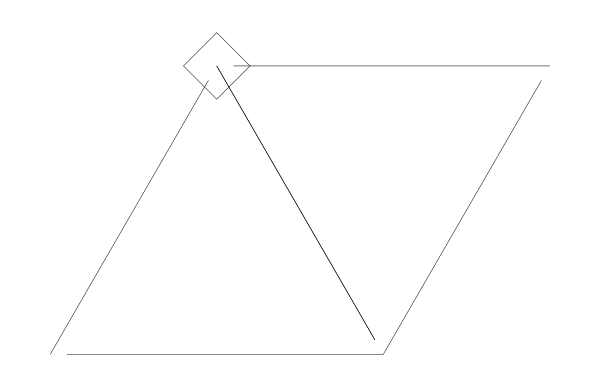

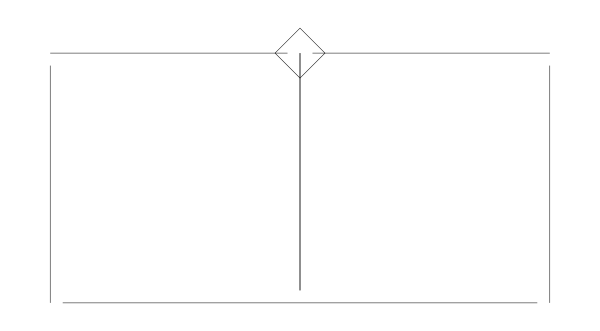

In [236]:

def get_poly(num_elem=3,invert=False,edge=[],phase=False,R=0.95):
    '''
        Get polyhedron
        num_elem, number of sides
        invert, invert horizontally or not, or..draw the other way round..
        edge, list of edge numbers which are to be extended fully instead of upto R
        phase, should the gap be first clockwise or counterclockwise
        R, how long should the line be (relative)
    '''

    theta=2*np.pi/num_elem
    v1,v2 = get_poly_basis(num_elem)

    ## Construct the unit cell
    unitcell = Path()
    #start,end coord
    r0=0
    r1=0
    #displacement
    d1=0
    ns = range(num_elem)
    # if phase:
    #     list(ns).reverse()
    
    ## Go through all linepieces
    ## Strategy is to rota
    for n in ns:
        ## Determine the rotation of a linepiece (before translation)
        if invert:
            rot = np.conjugate(np.exp((n+2)*1j*theta))
        else:
            rot = np.exp(n*1j*theta)
       
        ## Find edges that need to be fully extended
        if abs(n) in edge:
            R_ = 1
        else:
            R_ = R
        
        if phase:
            r0,r1 = ((1-R_)*rot, rot)
        else:
            r0,r1 = (0, R_*rot)
        
        ## Append and translate according to base vector
        unitcell.append(spt.Line(r0,r1).translated(d1))
        ## Starting position for the next linepiece is simply 
        d1 = d1 + rot
    
    return unitcell

# ## Two triangles, one upside down and displaced
# unitcell=get_poly(3, False,edge=[1])
# unitcell2=get_poly(3, True,edge=[1])
# disp_svg([unitcell,unitcell2])
testline = spt.polygon(-0.1,.1j,.1,-.1j)

# ## Two triangles, one upside down and displaced
unitcell=get_poly(3, invert=True,edge=[],phase=True)
unitcell2=get_poly(3, invert=False,edge=[],phase=True)

disp_svg([unitcell,unitcell2.translated(0),testline])


# ## Two squares, one upside down and displaced

unitcell=get_poly(4, invert=True,edge=[],phase=True)
unitcell2=get_poly(4, invert=False,edge=[],phase=True)

disp_svg([unitcell,unitcell2.translated(0),testline])

0j
(1+0j)
(2+0j)
(3+0j)
(0.4999999999999999+0.8660254037844387j)
(1.5+0.8660254037844387j)
(2.5+0.8660254037844387j)
(3.5+0.8660254037844387j)
(0.9999999999999998+1.7320508075688774j)
(1.9999999999999998+1.7320508075688774j)
(3+1.7320508075688774j)
(4+1.7320508075688774j)
(1.4999999999999996+2.598076211353316j)
(2.4999999999999996+2.598076211353316j)
(3.4999999999999996+2.598076211353316j)
(4.5+2.598076211353316j)


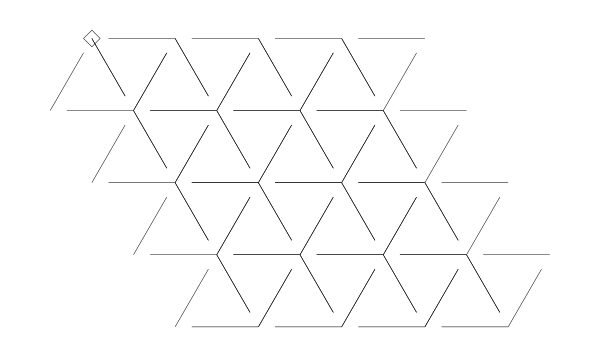

In [305]:
## Basis vectors 
## Theta is considered to be starting from unit circle 0

N_POLY = 3

##Basis vectors of lattice
v1,v2 = get_poly_basis(N_POLY)
paths=[]

n_a1 = 4
n_a2 = 4 ## vertical


for a2 in range(0,n_a2):
    for a1 in range(n_a1):
        elem1=get_poly(N_POLY, invert=True,edge=[],phase=True,R=0.8)
        elem2=get_poly(N_POLY, invert=False,edge=[],phase=True,R=0.8)


        v_d = v1.c*a1 + v2.c*a2 ##Displacement vector     
        print(v_d)       
        paths.append(elem1.translated(v_d))
        paths.append(elem2.translated(v_d))

zero = spt.polygon(-0.1,.1j,.1,-.1j)
paths.append(zero)

disp_svg(paths)

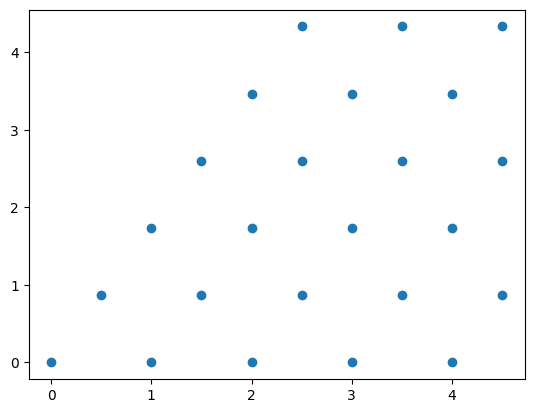

In [360]:
@dataclass
class BoxShape():
    l: float
    r: float
    u: float
    d: float

    def isin_mask(self, xs, ys):
        return (xs > self.l) & (xs < self.r) & (ys < self.u) & (ys > self.d)
@dataclass
class CircleShape():
    x0: float
    y0: float
    R0: float
    
    def isin_mask(self, xs, ys):
        return ((xs-self.x0)**2 + (ys-self.y0)**2) < self.R0**2


def construct_grid(v1,v2,shape,gridsize=(20,20)):
    a1,a2 = gridsize
    xs = np.arange(a1)
    ys = np.arange(a2)
    XS, YS = np.meshgrid(xs,ys)
    res = XS[:,:,np.newaxis]*v1.v + YS[:,:,np.newaxis]*v2.v
    import matplotlib.pyplot as plt
    x = res[:,:,0]
    y = res[:,:,1]

    mask = shape.isin_mask(x,y)
    # plt.scatter(x[mask],y[mask])
    return res[mask]
res = construct_grid(v1,v2,shape=CircleShape(5,5,5),gridsize=(20,20))
res = construct_grid(v1,v2,shape=BoxShape(-5,5,5,-5),gridsize=(20,20))

plt.scatter(res[:,0],res[:,1])

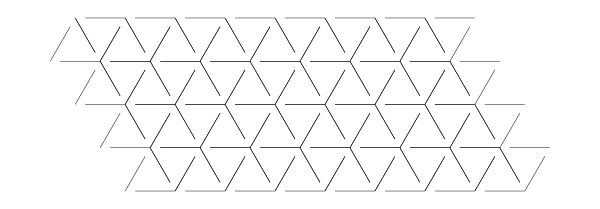

In [450]:
## Basis vectors 
## Theta is considered to be starting from unit circle 0

N_POLY = 3

##Basis vectors of lattice
v1,v2 = get_poly_basis(N_POLY)
paths=[]

n_a1 = 8
n_a2 = 4 ## vertical

# n_a1 = 1
# n_a2 = 1 ## vertical
shape = BoxShape(1,8,5,-5)
shape = CircleShape(1,8,500)
gridpoints = construct_grid(v1,v2,shape=shape,gridsize=(n_a1,n_a2))

for (x,y) in gridpoints:
        elem1=get_poly(N_POLY, invert=True,edge=[],phase=True,R=0.8)
        elem2=get_poly(N_POLY, invert=False,edge=[],phase=True,R=0.8)

        v_d = vec2(x,y) ##Displacement vector     
        paths.append(elem1.translated(v_d.c))
        paths.append(elem2.translated(v_d.c))

zero = spt.polygon(-0.1,.1j,.1,-.1j)
# paths.append(zero)

disp_svg(paths)

In [438]:
def test_approx_equal(line1,line2, tol=1e-3):

    return (abs((line1.start - line2.start)) / abs(line2.start)) < tol

test_approx_equal(line1,line3)

False

In [451]:
## Find duplicates in paths
seen = []
def check_seen(line):
    for s in seen:
        if test_approx_equal(line,s):
            return True
    return False

all_lines = spt.Path()
removed_count = 0
for path in paths:
    for line in path._segments:
        if check_seen(line):
            path.remove(line)
            removed_count+=1
            # print(f'removing {line}')
        else:
            # print(f'didnt see {line}, appending')
            seen.append(line)
        
print(f'Removed {removed_count} lines')

Removed 60 lines


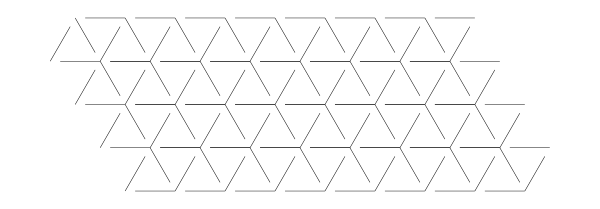

In [452]:
disp_svg(paths)

In [453]:
save_svg(paths, name='aux', params='some')
